# Basis embedding (pennylane)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Basis embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import pennylane as qml
from pennylane import numpy as pnp

### Prerequisites

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

## 1) Generating an artificial image of the sky (frequency domain)

In [3]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 4 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 9.8587456e+01+3.3782639e+01j  3.8334026e+01+1.1626357e+01j
   6.7983337e+01+6.2818794e+01j  6.8105250e-03+6.4782505e-03j]
 [ 5.0832559e-03-2.4537353e-03j  8.8615257e+01+1.8924772e+01j
  -2.6433768e-03-3.7006193e-04j -8.8249857e-04+1.8508667e-02j]
 [-7.6915044e-03-2.3537755e-03j  3.2168404e+01+3.2203594e+01j
   5.4618446e+01+4.7412281e+01j  9.6801883e-03-4.3218578e-03j]
 [-1.2925935e-02+7.7506769e-03j -1.8307939e-02-1.1260473e-02j
   1.6206575e-03+5.1165307e-03j  7.5174887e-03+6.0825865e-03j]]


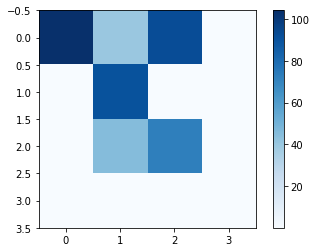

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[380.2952   +206.79161j    38.687878 -235.52649j
   62.05018   +81.25119j   -86.74555   +82.626015j ]
 [137.05556   -60.013844j  -24.004463   -6.7358932j
   86.83314  +158.36937j   194.45554   +43.448303j ]
 [203.10574  +168.89532j     0.9236748 -58.346966j
  239.27507  +119.107315j  -48.954075  -94.55572j  ]
 [ 99.190025 +117.26398j   153.2889    +31.155867j
  124.76144   -18.853477j   17.181046   +5.645638j ]]


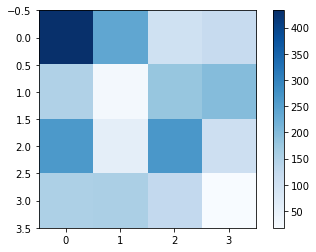

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: ' + str(test_imag))

Reals MSE: 9.618802e-13
Imaginaries MSE: 3.2960283e-13


C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcpara

(<Figure size 432x504 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x25f61b417c0>)

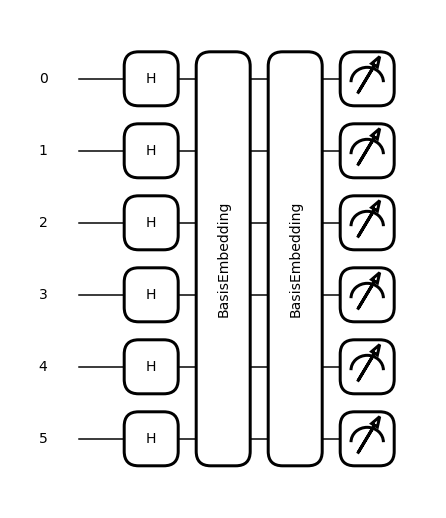

In [8]:
from pennylane.templates.embeddings import BasisEmbedding
# quantum device where you want to run and how many Qubits
dev = qml.device('default.qubit', wires=6)

@qml.qnode(dev)
def circuit(data):
    for i in range(6):
        qml.Hadamard(i)
    for i in range(len(data)):
        BasisEmbedding(features=data[i], wires=range(6),do_queue=True)
    return  qml.state()

data=[[1,0,1,1,1,0],
      [1,0,0,0,0,1]]

circuit(data)

qml.draw_mpl(circuit)(data)

## 3) Data encoding: basis embedding (non-conventional domain)

In [14]:
from pennylane.templates.embeddings import BasisEmbedding

# vectorize input data
data = visibilities.flatten()

# get binary representations of real and imaginary parts
data_reals = []
data_imags = []
for i in range(0, len(data)):
    data_reals.append(float_to_bin_real(data[i].real))
    data_imags.append(float_to_bin_imag(data[i].imag))

# combine binary representations into a single array (reals then imaginaries)
data_binaries = data_reals + data_imags 

# sparse all binary representations strings into single characters
data_binary = []
for i in range(0, len(data_binaries)):
    data_binary.append([*data_binaries[i]])

# make all character-strings integers
inp = []
for i in range(0, len(data_binary)):
    tmp = []
    for j in range(0, len(data_binary[i])):  
        tmp.append(int(data_binary[i][j]))
    inp.append(tmp)

# n bits encoded onto n quibts
wires = range(32) 
print(len(inp[0]))
bas_dev = qml.device('default.mixed', wires) # simulator (MOTIVATION?)

# encoding
@qml.qnode(bas_dev)
def basis_encoding(inp):
    for i in wires:
        qml.Hadamard(i)
    for i in range(len(inp)):
        BasisEmbedding(features=inp[i], wires=wires, do_queue=True)
    return qml.state()

readout = basis_encoding(inp)
print(readout)

32


ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

## 4) Applying 2D IFT (fidelity test)

In [ ]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')